In [2]:
import numpy as np
from numpy.fft import fft
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from qutip import *
import random
import collections
import time
import threading

## 想定するqubit系

以下の非調和振動子ハミルトニアンを仮定する:
$$
\begin{align}
\hat{H}/\hbar &= \omega_{\rm q}\hat{a}^\dagger\hat{a} + \frac{\alpha}{2}\hat{a}^\dagger\hat{a}^\dagger\hat{a}\hat{a} + \varOmega\cos(\omega_{\rm d}t + \phi)(\hat{a}^\dagger + \hat{a})\\
&= 2\pi f_{\rm q}\hat{a}^\dagger\hat{a} + \frac{2\pi f_{\rm anharm}}{2}\hat{a}^\dagger\hat{a}^\dagger\hat{a}\hat{a} + 2\pi f_{\rm rabi}\cos(2\pi f_{\rm d}t + \phi)(\hat{a}^\dagger + \hat{a}).
\end{align}
$$
このハミルトニアンの下3順位までを考慮する. 

緩和は縦緩和と純位相緩和を仮定する. 
状態の時間発展は以下のマスター方程式で表される: 
$$
\frac{\mathrm{d}\hat{\rho}}{\mathrm{d}t}
=
-\frac{\mathrm{i}}{\hbar}
[\hat{H}/\hbar,\hat{\rho}]
+\frac{1}{2}\sum_j
(2\hat{L}_j\hat{\rho}\hat{L}_j^\dagger - \hat{L}_j^\dagger\hat{L}_j\hat{\rho}-\hat{\rho}\hat{L}_j^\dagger\hat{L}_j)
$$
ここで$\hat{L}_1=\sqrt{\gamma}\hat{a}$はレート$\gamma$の縦緩和, $\hat{L}_2=\sqrt{2\gamma_{\rm p}}\hat{a}^\dagger\hat{a}$はレート$\gamma_{\rm p}$の純位相緩和に対応するリンドブラッド演算子である. 

In [3]:
#Qubit パラメータ
f_q = 7500
f_anharm = -380

#演算子の定義
N = 3 # 非調和3準位系を考える
a = destroy(N) # 消滅演算子
P0 = basis(N,0) * basis(N,0).dag() # |0><0|
P1 = basis(N,1) * basis(N,1).dag() # |1><1|
P2 = basis(N,2) * basis(N,2).dag() # |2><2|


"""ハミルトニアン"""
# qubitの自由ハミルトニアン
H_q = 2*np.pi * f_q * a.dag() * a + (2*np.pi*f_anharm / 2) * a.dag() * a.dag() * a * a
# 駆動ハミルトニアンの時間無依存部分
H_d = 2*np.pi * (a + a.dag())
f_d = 7500

# 全体のハミルトニアン
def H_tot(w):
    H_tot = [H_q, [H_d, np.real(w)]] 
    return H_tot


#リンドブラッド演算子
gamma = 0.1
L1 = np.sqrt(gamma) * a # 縦緩和
gamma_p = 1
L2 = np.sqrt(2*gamma_p) * a.dag() * a # 純位相緩和


#初期状態
ini_state = basis(N,0)   #　|0>

ini = 0
state = ini_state
s_input = []

#信号の入力を管理する関数
def input_manager():
    global ts, s_input, qstates, ini,state
    while(1):
        ts+=5
        time.sleep(0.001)
        if (ts%10 == 0):
            if(len(s_input)>100):
                t_list = np.linspace(s_input[0][0], s_input[100][0], 100+1)
                w = np.zeros(len(t_list), dtype=np.float32)
                for x in range(len(t_list)):
                    w[x] = s_input[x][1]+s_input[x][2]
                result = sesolve(H_tot(w), state, t_list)
                for i in range(100):
                    qstates.append([s_input[i][1],s_input[i][2],result.states[i][0][0][0]*result.states[i].dag()[0][0][0]\
                                    ,result.states[i][1][0][0]*result.states[i].dag()[0][0][1]\
                                    ,result.states[i][2][0][0]*result.states[i].dag()[0][0][2]])
                s_input = s_input[100:]
                state = result.states[-1]
                
            elif(len(s_input)>10):
                t_list = np.linspace(s_input[0][0], s_input[10][0], 10+1)
                w = np.zeros(len(t_list), dtype=np.float32)
                for x in range(len(t_list)-1):
                    w[x] = s_input[x][1]+s_input[x][2]
                result = sesolve(H_tot(w), state, t_list)
                for i in range(10):
                    qstates.append([s_input[i][1],s_input[i][2],result.states[i][0][0][0]*result.states[i].dag()[0][0][0]\
                                    ,result.states[i][1][0][0]*result.states[i].dag()[0][0][1]\
                                    ,result.states[i][2][0][0]*result.states[i].dag()[0][0][2]])
                s_input = s_input[10:]
                state = result.states[-1]
                
            elif(len(s_input)>1):
                t_list = np.linspace(s_input[0][0], s_input[1][0],  1+1)
                w = np.zeros(len(t_list), dtype=np.float32)
                for x in range(len(t_list)-1):
                    w[x] = s_input[x][1]+s_input[x][2]
                result = sesolve(H_tot(w), state, t_list)
                qstates.append([s_input[0][1],s_input[0][2],result.states[0][0][0][0]*result.states[0].dag()[0][0][0]\
                                ,result.states[0][1][0][0]*result.states[0].dag()[0][0][1]\
                                ,result.states[0][2][0][0]*result.states[0].dag()[0][0][2]])
                s_input = s_input[1:]
                state = result.states[-1]
                
            elif(len(s_input)==1):
                t_list = np.linspace(s_input[0][0]-3.3333333333333335e-05,s_input[0][0],  1+1)
                w = np.zeros(len(t_list), dtype=np.float32)
                for x in range(len(t_list)-1):
                    w[x] = s_input[x][1]+s_input[x][2]
                result = sesolve(H_tot(w), state, t_list)
                qstates.append([s_input[0][1],s_input[0][2],result.states[0][0][0][0]*result.states[0].dag()[0][0][0]\
                                ,result.states[0][1][0][0]*result.states[0].dag()[0][0][1]\
                                ,result.states[0][2][0][0]*result.states[0].dag()[0][0][2]])
                s_input = s_input[1:]
                state = result.states[-1]
            
            if(ini==1):
                ini=0
                state = ini_state
                qstates.append([0,0,state[0][0][0]*state.dag()[0][0][0]\
                    ,state[1][0][0]*state.dag()[0][0][1]\
                    ,state[2][0][0]*state.dag()[0][0][2]])

#量子状態の初期化の関数
def initialize():
    global ini
    ini = 1

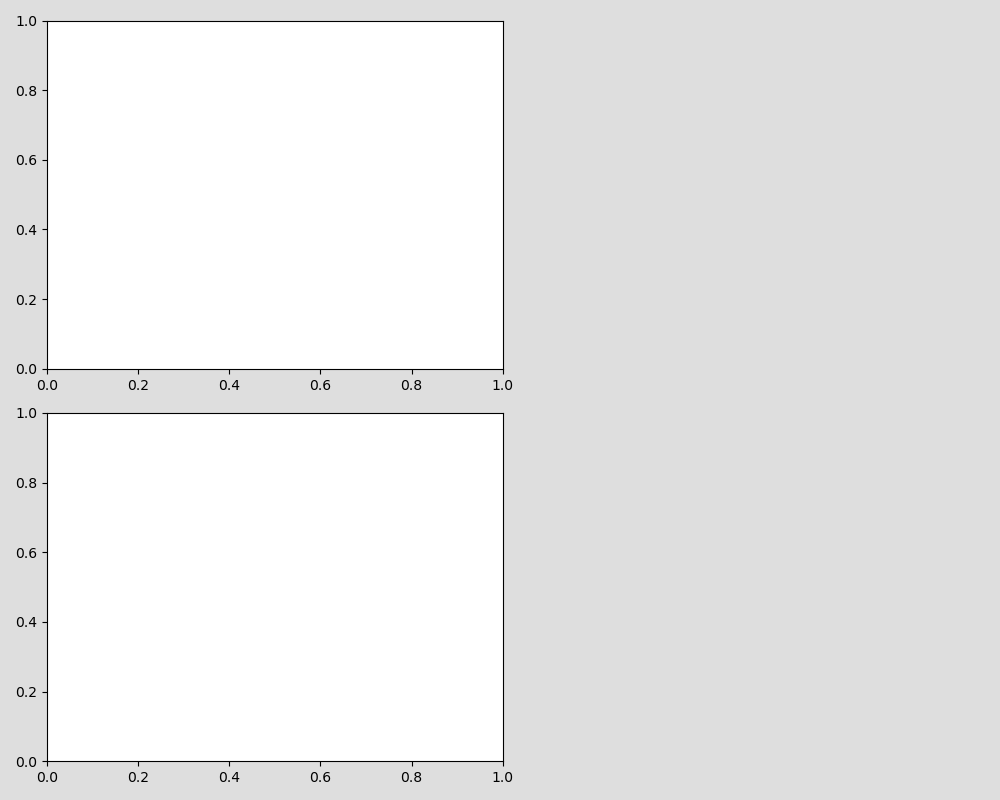

In [3]:
#表示用のセル

%matplotlib widget

qstates = []
qsave = (0, 0, 0)
count = 0

fig = plt.figure(figsize=(10,8), facecolor='#DEDEDE', tight_layout=True)

def my_function(i):
    global qstates, count, qsave
    
    ctrl_input_i.popleft()
    ctrl_input_q.popleft()
    
    q0_state0.popleft()
    q0_state1.popleft()
    q0_state2.popleft()
    
    if len(qstates)>=3:
        ctrl_input_i.append(qstates[0][0])
        ctrl_input_q.append(qstates[0][1])
        
        q0_state0.append(qstates[0][2])
        q0_state1.append(qstates[0][3])
        q0_state2.append(qstates[0][4])
        
        qsave = (qstates[0][2], qstates[0][3], qstates[0][4])
        qstates = qstates[3:]
    else:
        ctrl_input_i.append(0)
        ctrl_input_q.append(0)
    
        q0_state0.append(qsave[0])
        q0_state1.append(qsave[1])
        q0_state2.append(qsave[2])
   
    count += 1
    alist = np.arange(0+count,100+count,1)
    time.sleep(0.015)
        
    # clear axis
    ax1.cla()
    ax2.cla()
    
    ax1.set_title("Qubit State")
    ax2.set_title("Input Control")
 
    # 量子状態をプロット   
    ax1.set_ylim(-0.3,1.3)
    ax1.plot(alist/10,q0_state0,color="blue", label="p0")
    ax1.scatter(alist[-1]/10, q0_state0[-1],color="blue")

    ax1.plot(alist/10,q0_state1,color="red", label="p1")
    ax1.scatter(alist[-1]/10, q0_state1[-1],color="red")
    
    ax1.plot(alist/10,q0_state2,color="green", label="p2")
    ax1.scatter(alist[-1]/10,q0_state2[-1],color="green")
    ax1.legend(loc=(0.05, 0.75))
    ax1.set_xlabel("time[ns]", {"fontsize":15})
    ax1.set_ylabel("probability", {"fontsize":15})
    
    # 制御信号をプロット
    #ax2.set_ylim(-1,1)
    ax2.set_ylim(-60,60)
    ax2.plot(alist/10, ctrl_input_i,color="blue", label="I")
    ax2.scatter(alist[-1]/10, ctrl_input_i[-1],color="blue")
    
    ax2.plot(alist/10, ctrl_input_q,color="red", label="Q")
    ax2.scatter(alist[-1]/10, ctrl_input_q[-1],color="red")
    
    ax2.set_xlabel("time[ns]", {"fontsize":15})
    ax2.set_ylabel("signal[amp]", {"fontsize":15})
    
    ax2.legend(loc=(0.05, 0.05))

# start collections with zeros
ctrl_input_i = collections.deque(np.zeros(100))
ctrl_input_q = collections.deque(np.zeros(100))
q0_state0 = collections.deque(np.zeros(100))
q0_state1 = collections.deque(np.zeros(100))
q0_state2 = collections.deque(np.zeros(100))

# define and adjust figure
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0,0], facecolor="white") 
ax2 = fig.add_subplot(gs[1,0], facecolor="white")   

# animate
ani = FuncAnimation(fig, my_function, interval=50)
plt.show()

In [4]:
# 入力管理のスレッドを作る
ts = 0
threading.Thread(target=input_manager).start()

In [5]:
# R(X/Y) gate
ts = 0
f_rabi = 50
f_d = 7500
phi = 0
s_input = []

samples = 300
ts_f = 0.01 # 0.01 us = 10 ns
I = 0 # X Gate
Q = 1 # Y Gate
for i in range(samples+1):
    s_input.append([ts+i*(ts_f/samples), f_rabi*(I*np.sin(2*np.pi*i*f_d*(ts_f/samples) + phi)),f_rabi*(Q*np.cos(2*np.pi*i*f_d*(ts_f/samples) + phi))])
    #s_input.append([ts+i*(ts_f/samples), (I*np.sin(2*np.pi*i*f_d*(ts_f/samples) + phi)),(Q*np.cos(2*np.pi*i*f_d*(ts_f/samples) + phi))])

In [6]:
#初期化
initialize()

In [8]:
#量子状態の確認
state

Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[ 0.86954114+0.00335154j]
 [-0.49197841+0.01336585j]
 [ 0.00661277+0.04027208j]]

In [4]:
result.states[i][0][0][0]*result.states[i].dag()[0][0][0]

NameError: name 'result' is not defined